# CSE 158 Assignment 2: Heart Rate Prediction from Fitness Activity Data

## Exploratory Data Analysis

**Author:** Min Myat  
**Course:** CSE 158/258 - Web Mining and Recommender Systems  
**Dataset:** FitRec - Endomondo Fitness Data

---

## Project Overview

This notebook presents an exploratory data analysis (EDA) of the FitRec dataset from Endomondo, a popular fitness tracking application. The dataset contains workout records with sequential sensor data including heart rate, speed, GPS coordinates, and various user characteristics.

### Predictive Task
Our goal is to **predict heart rate based on current activity data** such as speed, distance, sport type, and user characteristics. This analysis will help us understand the data structure, identify patterns, and determine which features are most relevant for heart rate prediction.

### Dataset Source
- **Paper:** "Modeling heart rate and activity data for personalized fitness recommendation" by Jianmo Ni, Larry Muhlstein, Julian McAuley (WWW, 2019)
- **URL:** https://sites.google.com/eng.ucsd.edu/fitrec-project/home
- **Data Version:** Re-sampled data with 10-second intervals (102,343 workouts / 887 users)

In [ ]:
# Run this cell first if you need to install required packages
# Uncomment the lines below if packages are not installed

# !pip install numpy pandas matplotlib seaborn
# !pip install ipykernel

# If using conda, you may need to run this in your terminal:
# conda install -n .conda ipykernel --update-deps --force-reinstall

print("Setup complete! You can now run the rest of the notebook.")

---
## Section 1: Setup and Data Loading

First, we'll import the necessary libraries and load the dataset.

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

In [ ]:
# Load the dataset
# The data is stored as a numpy array of dictionaries
data = np.load('processed_endomondoHR_proper_interpolate.npy', allow_pickle=True)

print(f"Data loaded successfully!")
print(f"Data type: {type(data)}")
print(f"Data shape: {data.shape}")
print(f"Total number of workouts: {len(data)}")

---
## Section 2: Data Inspection

Let's examine the structure of individual workout records to understand what features are available.

In [8]:
# Understanding the data structure:
# - data is a numpy array with shape (1,) containing a single element
# - data[0] gives us another array with shape (102992,) containing all workouts
# - Each workout is accessed via data[0][i] or data.item(0) for first level, then index

# Let's restructure the data for easier access
print("=" * 60)
print("EXAMINING DATA STRUCTURE")
print("=" * 60)

print(f"Original data shape: {data.shape}")
print(f"Original data dtype: {data.dtype}")

# The workouts are actually inside data[0] based on the output
# data[0] has shape (102992,) - these are our workouts
workouts = data[0]  # This is the array of workout dictionaries

print(f"\nWorkouts array shape: {workouts.shape}")
print(f"Workouts array dtype: {workouts.dtype}")
print(f"Total number of workouts: {len(workouts)}")

# Each element in workouts should be a dictionary
sample_workout = workouts[0]
print(f"\nSample workout type: {type(sample_workout)}")

# Helper function to get workout - now just returns the element directly
def get_workout_dict(workout):
    """Get workout as dictionary."""
    return workout

# Display the keys
if isinstance(sample_workout, dict):
    print(f"\nAvailable keys/fields ({len(sample_workout.keys())} total):")
    print("-" * 40)
    for key in sample_workout.keys():
        value = sample_workout[key]
        if isinstance(value, (list, np.ndarray)):
            arr = np.array(value)
            print(f"  {key}: array with {len(arr)} elements")
        else:
            print(f"  {key}: {value} (type: {type(value).__name__})")

EXAMINING DATA STRUCTURE
Original data shape: (1, 102992)
Original data dtype: object

Workouts array shape: (102992,)
Workouts array dtype: object
Total number of workouts: 102992

Sample workout type: <class 'dict'>

Available keys/fields (16 total):
----------------------------------------
  since_begin: array with 300 elements
  time_elapsed: array with 300 elements
  latitude: array with 300 elements
  gender: male (type: str)
  tar_heart_rate: array with 300 elements
  timestamp: array with 300 elements
  id: 396826535 (type: int)
  longitude: array with 300 elements
  since_last: array with 300 elements
  heart_rate: array with 300 elements
  sport: bike (type: str)
  altitude: array with 300 elements
  derived_speed: array with 300 elements
  tar_derived_speed: array with 300 elements
  distance: array with 300 elements
  userId: 10921915 (type: int)


In [9]:
# Display detailed view of the sample workout
# Note: sample_workout was converted to dict in the previous cell using get_workout_dict()

print("\n" + "=" * 60)
print("DETAILED VIEW OF SAMPLE WORKOUT")
print("=" * 60)

for key, value in sample_workout.items():
    print(f"\n{key}:")
    if isinstance(value, (list, np.ndarray)):
        arr = np.array(value)
        print(f"  Shape: {arr.shape}")
        print(f"  Dtype: {arr.dtype}")
        print(f"  First 5 values: {arr[:5]}")
        if len(arr) > 5:
            print(f"  Last 5 values: {arr[-5:]}")
    else:
        print(f"  Value: {value}")


DETAILED VIEW OF SAMPLE WORKOUT

since_begin:
  Shape: (300,)
  Dtype: float64
  First 5 values: [1378478.88921843 1378478.88921843 1378478.88921843 1378478.88921843
 1378478.88921843]
  Last 5 values: [1378478.88921843 1378478.88921843 1378478.88921843 1378478.88921843
 1378478.88921843]

time_elapsed:
  Shape: (300,)
  Dtype: float64
  First 5 values: [-0.12256753 -0.12212175 -0.12167597 -0.12123019 -0.12078441]
  Last 5 values: [0.00893754 0.00938332 0.0098291  0.01027488 0.01072066]

latitude:
  Shape: (300,)
  Dtype: float64
  First 5 values: [60.17334877 60.1732398  60.17298021 60.17247797 60.17186115]
  Last 5 values: [60.1626703  60.16213185 60.1613173  60.15921906 60.15882879]

gender:
  Value: male

tar_heart_rate:
  Shape: (300,)
  Dtype: float64
  First 5 values: [100.         113.3554688  120.21475199 119.1082212  120.56936179]
  Last 5 values: [151.43659431 149.53822266 143.79973378 140.71481656 141.70603275]

timestamp:
  Shape: (300,)
  Dtype: int64
  First 5 values: [

### Data Field Descriptions

Based on the FitRec documentation, here's what each field represents:

| Field | Description |
|-------|-------------|
| `userId` | Unique identifier for each user |
| `gender` | User's gender (male/female) |
| `sport` | Type of sport/activity (bike, run, etc.) |
| `id` | Unique workout identifier |
| `heart_rate` | **Normalized** heart rate values (Z-scores) - time series |
| `tar_heart_rate` | **Original/target** heart rate values (bpm) - time series |
| `derived_speed` | **Normalized** speed values - time series |
| `tar_derived_speed` | **Original** speed values - time series |
| `time_elapsed` | Normalized time elapsed during workout |
| `distance` | Normalized distance measurements |
| `altitude` | Altitude measurements |
| `longitude`, `latitude` | GPS coordinates |
| `timestamp` | Unix timestamps for each measurement |
| `since_begin` | Seconds since user's first ever workout |
| `since_last` | Seconds since user's most recent workout |

**Note:** The data has been re-sampled at 10-second intervals for consistency.

---
## Section 3: Basic Dataset Statistics

Let's compute overall statistics about the dataset.

In [10]:
# Extract basic information from all workouts
# Note: 'workouts' array was defined in cell-6 as data[0]

user_ids = []
sports = []
genders = []
workout_ids = []
sequence_lengths = []

for workout in workouts:
    user_ids.append(workout['userId'])
    sports.append(workout['sport'])
    genders.append(workout['gender'])
    workout_ids.append(workout['id'])
    sequence_lengths.append(len(workout['heart_rate']))

# Basic statistics
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nTotal number of workouts: {len(workouts):,}")
print(f"Total number of unique users: {len(set(user_ids)):,}")
print(f"Total number of unique sport types: {len(set(sports))}")
print(f"\nAverage workouts per user: {len(workouts) / len(set(user_ids)):.2f}")
print(f"\nSequence length statistics (time points per workout):")
print(f"  Min: {min(sequence_lengths)}")
print(f"  Max: {max(sequence_lengths)}")
print(f"  Mean: {np.mean(sequence_lengths):.2f}")
print(f"  Median: {np.median(sequence_lengths):.2f}")
print(f"  Std: {np.std(sequence_lengths):.2f}")

DATASET OVERVIEW

Total number of workouts: 102,992
Total number of unique users: 1,038
Total number of unique sport types: 39

Average workouts per user: 99.22

Sequence length statistics (time points per workout):
  Min: 300
  Max: 300
  Mean: 300.00
  Median: 300.00
  Std: 0.00


In [11]:
# Create a summary table
summary_data = {
    'Metric': [
        'Total Workouts',
        'Unique Users',
        'Unique Sport Types',
        'Avg Workouts per User',
        'Avg Sequence Length',
        'Min Sequence Length',
        'Max Sequence Length'
    ],
    'Value': [
        f"{len(workouts):,}",
        f"{len(set(user_ids)):,}",
        f"{len(set(sports))}",
        f"{len(workouts) / len(set(user_ids)):.2f}",
        f"{np.mean(sequence_lengths):.2f}",
        f"{min(sequence_lengths)}",
        f"{max(sequence_lengths)}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\nDataset Summary Table:")
print(summary_df.to_string(index=False))


Dataset Summary Table:
               Metric   Value
       Total Workouts 102,992
         Unique Users   1,038
   Unique Sport Types      39
Avg Workouts per User   99.22
  Avg Sequence Length  300.00
  Min Sequence Length     300
  Max Sequence Length     300


---
## Section 4: Sport Type Analysis

One of our key questions is: **Which sport type is most common in the dataset?**

In [12]:
# Count sport types
sport_counts = Counter(sports)

print("=" * 60)
print("SPORT TYPE DISTRIBUTION")
print("=" * 60)
print(f"\nTotal unique sport types: {len(sport_counts)}")
print("\nSport type counts (sorted by frequency):")
print("-" * 40)

# Sort by count (descending)
sorted_sports = sorted(sport_counts.items(), key=lambda x: x[1], reverse=True)

for sport, count in sorted_sports:
    percentage = (count / len(sports)) * 100
    print(f"  {sport}: {count:,} workouts ({percentage:.2f}%)")

# Identify the most common sport
most_common_sport = sorted_sports[0]
print("\n" + "=" * 60)
print(f"MOST COMMON SPORT: {most_common_sport[0].upper()}")
print(f"Count: {most_common_sport[1]:,} workouts")
print(f"Percentage: {(most_common_sport[1] / len(sports)) * 100:.2f}%")
print("=" * 60)

SPORT TYPE DISTRIBUTION

Total unique sport types: 39

Sport type counts (sorted by frequency):
----------------------------------------
  bike: 48,493 workouts (47.08%)
  run: 39,201 workouts (38.06%)
  mountain bike: 7,711 workouts (7.49%)
  bike (transport): 3,234 workouts (3.14%)
  indoor cycling: 1,320 workouts (1.28%)
  cross-country skiing: 630 workouts (0.61%)
  walk: 618 workouts (0.60%)
  orienteering: 553 workouts (0.54%)
  core stability training: 258 workouts (0.25%)
  hiking: 193 workouts (0.19%)
  fitness walking: 186 workouts (0.18%)
  roller skiing: 158 workouts (0.15%)
  skate: 124 workouts (0.12%)
  kayaking: 60 workouts (0.06%)
  circuit training: 53 workouts (0.05%)
  rowing: 46 workouts (0.04%)
  weight training: 31 workouts (0.03%)
  downhill skiing: 24 workouts (0.02%)
  soccer: 21 workouts (0.02%)
  snowshoeing: 15 workouts (0.01%)
  golf: 11 workouts (0.01%)
  horseback riding: 7 workouts (0.01%)
  tennis: 5 workouts (0.00%)
  treadmill running: 5 workouts (0.

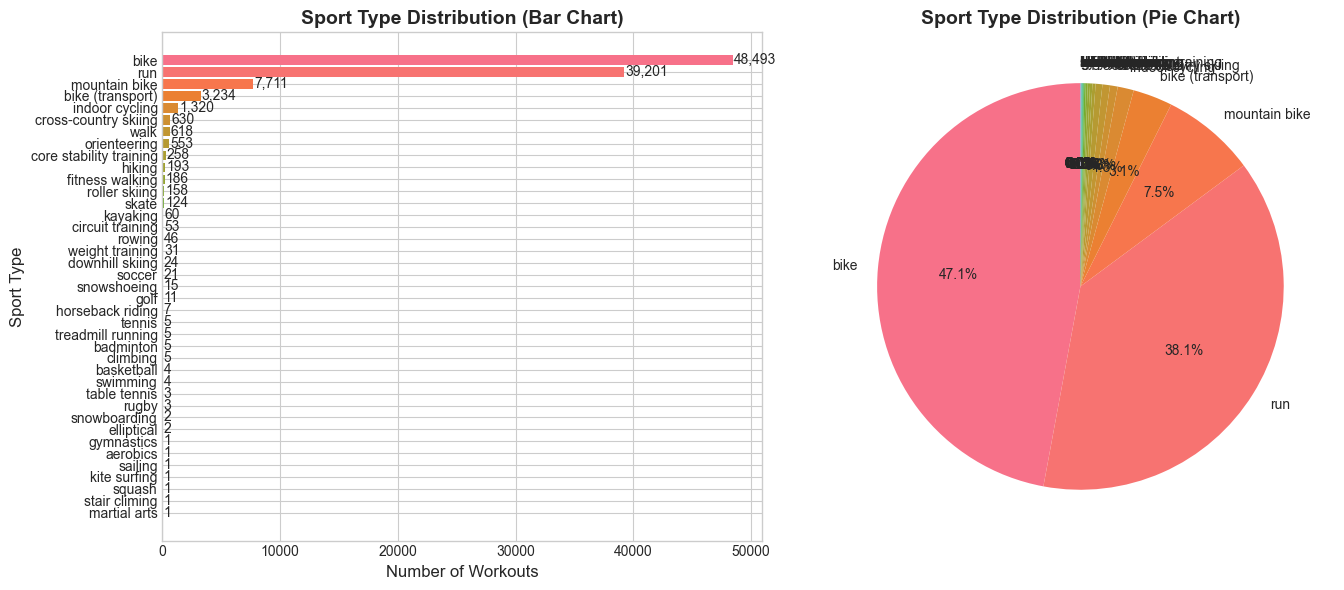


Figure saved as 'sport_distribution.png'


In [13]:
# Visualization: Sport Type Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
sport_names = [s[0] for s in sorted_sports]
sport_values = [s[1] for s in sorted_sports]
colors = sns.color_palette('husl', len(sport_names))

axes[0].barh(sport_names[::-1], sport_values[::-1], color=colors[::-1])
axes[0].set_xlabel('Number of Workouts', fontsize=12)
axes[0].set_ylabel('Sport Type', fontsize=12)
axes[0].set_title('Sport Type Distribution (Bar Chart)', fontsize=14, fontweight='bold')

# Add value labels
for i, (name, val) in enumerate(zip(sport_names[::-1], sport_values[::-1])):
    axes[0].text(val + 100, i, f'{val:,}', va='center', fontsize=10)

# Pie chart
axes[1].pie(sport_values, labels=sport_names, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('Sport Type Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('sport_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'sport_distribution.png'")

---
## Section 5: User Analysis

Let's analyze user activity patterns and workout distribution across users.

In [14]:
# Count workouts per user
user_workout_counts = Counter(user_ids)

print("=" * 60)
print("USER ACTIVITY ANALYSIS")
print("=" * 60)

workout_counts = list(user_workout_counts.values())

print(f"\nWorkouts per user statistics:")
print(f"  Min workouts: {min(workout_counts)}")
print(f"  Max workouts: {max(workout_counts)}")
print(f"  Mean workouts: {np.mean(workout_counts):.2f}")
print(f"  Median workouts: {np.median(workout_counts):.2f}")
print(f"  Std: {np.std(workout_counts):.2f}")

# Find most active users
sorted_users = sorted(user_workout_counts.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop 10 most active users:")
print("-" * 40)
for i, (user_id, count) in enumerate(sorted_users[:10], 1):
    print(f"  {i}. User {user_id}: {count} workouts")

USER ACTIVITY ANALYSIS

Workouts per user statistics:
  Min workouts: 1
  Max workouts: 917
  Mean workouts: 99.22
  Median workouts: 57.00
  Std: 118.45

Top 10 most active users:
----------------------------------------
  1. User 2734298: 917 workouts
  2. User 9051351: 908 workouts
  3. User 4535678: 775 workouts
  4. User 1063624: 749 workouts
  5. User 2486861: 679 workouts
  6. User 804068: 637 workouts
  7. User 1520156: 598 workouts
  8. User 1998312: 585 workouts
  9. User 14066832: 582 workouts
  10. User 2102320: 560 workouts


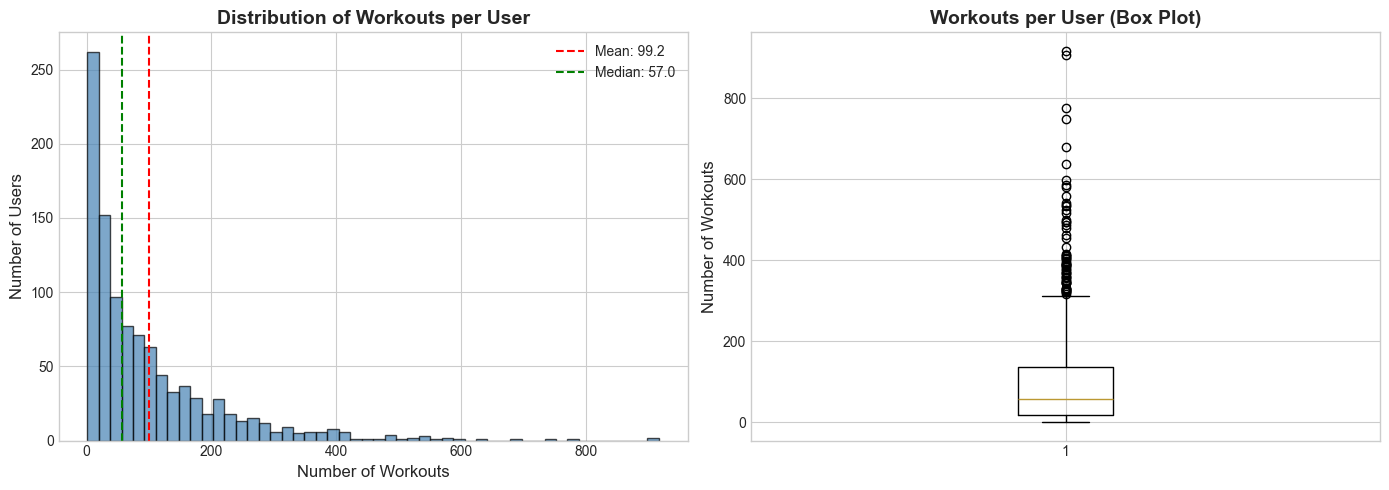

In [15]:
# Visualization: Workouts per user distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(workout_counts, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Number of Workouts', fontsize=12)
axes[0].set_ylabel('Number of Users', fontsize=12)
axes[0].set_title('Distribution of Workouts per User', fontsize=14, fontweight='bold')
axes[0].axvline(np.mean(workout_counts), color='red', linestyle='--', 
                label=f'Mean: {np.mean(workout_counts):.1f}')
axes[0].axvline(np.median(workout_counts), color='green', linestyle='--', 
                label=f'Median: {np.median(workout_counts):.1f}')
axes[0].legend()

# Box plot
axes[1].boxplot(workout_counts, vert=True)
axes[1].set_ylabel('Number of Workouts', fontsize=12)
axes[1].set_title('Workouts per User (Box Plot)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('user_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# User activity percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print("\nWorkouts per user - Percentile analysis:")
print("-" * 40)
for p in percentiles:
    val = np.percentile(workout_counts, p)
    print(f"  {p}th percentile: {val:.0f} workouts")


Workouts per user - Percentile analysis:
----------------------------------------
  10th percentile: 6 workouts
  25th percentile: 19 workouts
  50th percentile: 57 workouts
  75th percentile: 136 workouts
  90th percentile: 246 workouts
  95th percentile: 343 workouts
  99th percentile: 540 workouts


---
## Section 6: Gender Analysis

Let's examine the gender distribution and how it relates to sport types.

In [17]:
# Gender distribution
gender_counts = Counter(genders)

print("=" * 60)
print("GENDER ANALYSIS")
print("=" * 60)

print("\nGender distribution (by workouts):")
for gender, count in sorted(gender_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(genders)) * 100
    print(f"  {gender}: {count:,} workouts ({percentage:.2f}%)")

# Gender distribution by unique users
user_gender_map = {}
for workout in workouts:
    user_gender_map[workout['userId']] = workout['gender']

user_gender_counts = Counter(user_gender_map.values())

print("\nGender distribution (by unique users):")
for gender, count in sorted(user_gender_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(user_gender_map)) * 100
    print(f"  {gender}: {count:,} users ({percentage:.2f}%)")

GENDER ANALYSIS

Gender distribution (by workouts):
  male: 96,239 workouts (93.44%)
  female: 5,904 workouts (5.73%)
  unknown: 849 workouts (0.82%)

Gender distribution (by unique users):
  male: 927 users (89.31%)
  female: 96 users (9.25%)
  unknown: 15 users (1.45%)


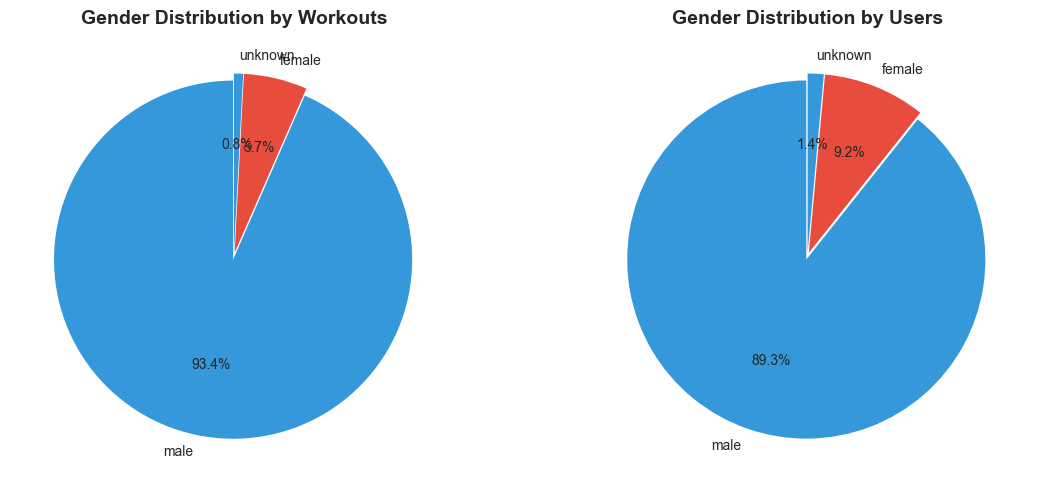

In [18]:
# Visualization: Gender distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# By workouts
gender_labels = list(gender_counts.keys())
gender_values = list(gender_counts.values())
colors = ['#3498db', '#e74c3c'] if 'male' in gender_labels else sns.color_palette('husl', len(gender_labels))

axes[0].pie(gender_values, labels=gender_labels, autopct='%1.1f%%', 
            colors=colors, startangle=90, explode=[0.02]*len(gender_labels))
axes[0].set_title('Gender Distribution by Workouts', fontsize=14, fontweight='bold')

# By users
user_gender_labels = list(user_gender_counts.keys())
user_gender_values = list(user_gender_counts.values())

axes[1].pie(user_gender_values, labels=user_gender_labels, autopct='%1.1f%%', 
            colors=colors, startangle=90, explode=[0.02]*len(user_gender_labels))
axes[1].set_title('Gender Distribution by Users', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('gender_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
# Cross-analysis: Gender vs Sport Type
gender_sport = defaultdict(lambda: defaultdict(int))

for workout in workouts:
    gender_sport[workout['gender']][workout['sport']] += 1

print("\nGender vs Sport Type Cross-Analysis:")
print("=" * 60)

# Create a DataFrame for better visualization
gender_sport_df = pd.DataFrame(gender_sport).fillna(0).astype(int)
gender_sport_df['Total'] = gender_sport_df.sum(axis=1)
gender_sport_df = gender_sport_df.sort_values('Total', ascending=False)

print(gender_sport_df)


Gender vs Sport Type Cross-Analysis:
                          male  female  unknown  Total
bike                     46031    1991      471  48493
run                      35767    3122      312  39201
mountain bike             7499     164       48   7711
bike (transport)          3171      63        0   3234
indoor cycling            1262      49        9   1320
cross-country skiing       499     131        0    630
walk                       453     165        0    618
orienteering               537      16        0    553
core stability training    226      28        4    258
hiking                     166      27        0    193
fitness walking             84     101        1    186
roller skiing              156       2        0    158
skate                      117       7        0    124
kayaking                    58       2        0     60
circuit training            45       8        0     53
rowing                      33      13        0     46
weight training            

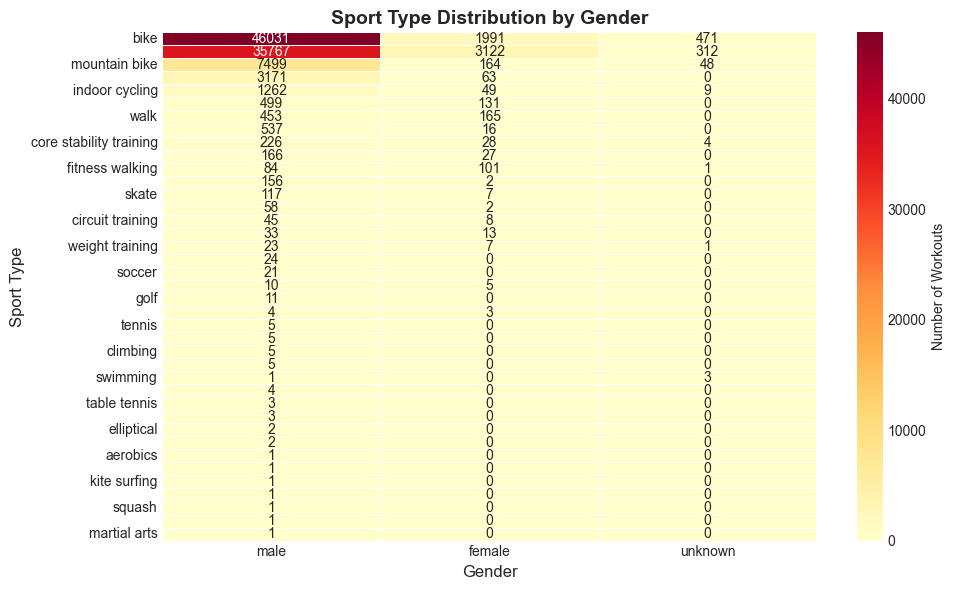

In [20]:
# Visualization: Gender vs Sport heatmap
plt.figure(figsize=(10, 6))

# Remove the Total column for the heatmap
heatmap_df = gender_sport_df.drop('Total', axis=1)

sns.heatmap(heatmap_df, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Number of Workouts'})
plt.title('Sport Type Distribution by Gender', fontsize=14, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Sport Type', fontsize=12)
plt.tight_layout()
plt.savefig('gender_sport_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 7: Heart Rate Analysis

Heart rate is our **target variable** for prediction. Let's analyze its distribution and relationships with other features.

In [21]:
# Collect heart rate data
# We'll use tar_heart_rate (original values) for analysis
all_heart_rates = []
all_normalized_hr = []
hr_by_sport = defaultdict(list)
hr_by_gender = defaultdict(list)

for workout in workouts:
    hr = workout.get('tar_heart_rate', workout.get('heart_rate', []))
    hr_normalized = workout.get('heart_rate', [])
    sport = workout['sport']
    gender = workout['gender']
    
    if len(hr) > 0:
        all_heart_rates.extend(hr)
        all_normalized_hr.extend(hr_normalized)
        # Store mean HR per workout for each sport/gender
        hr_by_sport[sport].append(np.mean(hr))
        hr_by_gender[gender].append(np.mean(hr))

all_heart_rates = np.array(all_heart_rates)
all_normalized_hr = np.array(all_normalized_hr)

print("=" * 60)
print("HEART RATE ANALYSIS")
print("=" * 60)

print(f"\nTotal heart rate measurements: {len(all_heart_rates):,}")
print(f"\nOriginal Heart Rate (tar_heart_rate) Statistics:")
print(f"  Min: {np.min(all_heart_rates):.2f} bpm")
print(f"  Max: {np.max(all_heart_rates):.2f} bpm")
print(f"  Mean: {np.mean(all_heart_rates):.2f} bpm")
print(f"  Median: {np.median(all_heart_rates):.2f} bpm")
print(f"  Std: {np.std(all_heart_rates):.2f} bpm")

print(f"\nNormalized Heart Rate (heart_rate) Statistics:")
print(f"  Min: {np.min(all_normalized_hr):.4f}")
print(f"  Max: {np.max(all_normalized_hr):.4f}")
print(f"  Mean: {np.mean(all_normalized_hr):.4f}")
print(f"  Std: {np.std(all_normalized_hr):.4f}")

HEART RATE ANALYSIS

Total heart rate measurements: 30,897,600

Original Heart Rate (tar_heart_rate) Statistics:
  Min: 50.00 bpm
  Max: 200.00 bpm
  Mean: 136.97 bpm
  Median: 139.08 bpm
  Std: 21.73 bpm

Normalized Heart Rate (heart_rate) Statistics:
  Min: -18.7861
  Max: 12.9802
  Mean: -0.3683
  Std: 4.6023


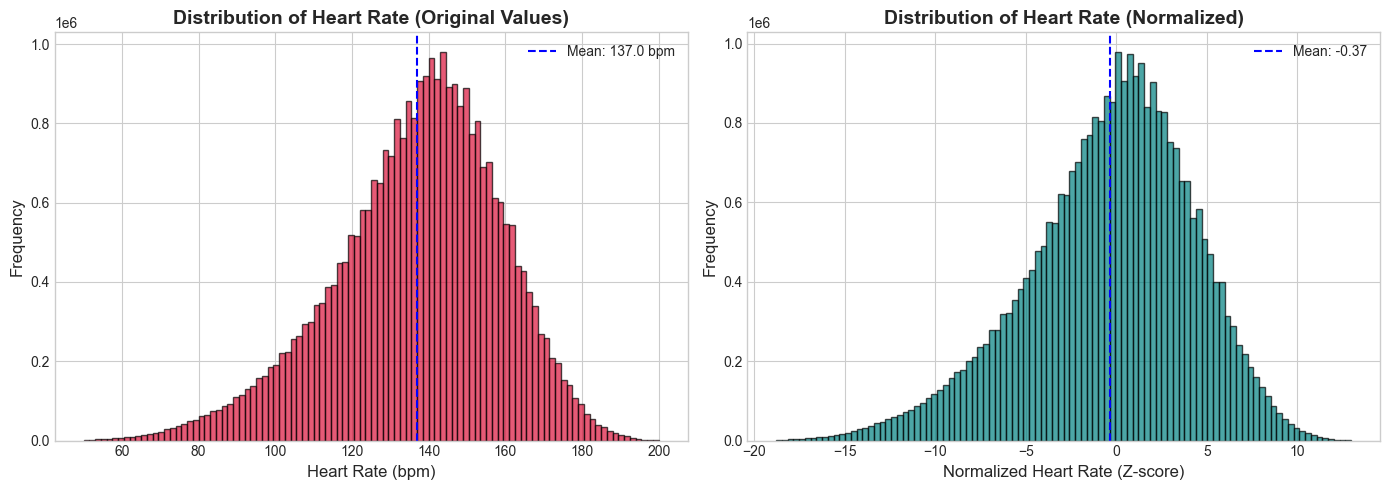

In [22]:
# Visualization: Heart Rate Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original heart rate distribution
axes[0].hist(all_heart_rates, bins=100, edgecolor='black', alpha=0.7, color='crimson')
axes[0].set_xlabel('Heart Rate (bpm)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Heart Rate (Original Values)', fontsize=14, fontweight='bold')
axes[0].axvline(np.mean(all_heart_rates), color='blue', linestyle='--', 
                label=f'Mean: {np.mean(all_heart_rates):.1f} bpm')
axes[0].legend()

# Normalized heart rate distribution
axes[1].hist(all_normalized_hr, bins=100, edgecolor='black', alpha=0.7, color='teal')
axes[1].set_xlabel('Normalized Heart Rate (Z-score)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Heart Rate (Normalized)', fontsize=14, fontweight='bold')
axes[1].axvline(np.mean(all_normalized_hr), color='blue', linestyle='--', 
                label=f'Mean: {np.mean(all_normalized_hr):.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('heart_rate_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:
# Heart Rate by Sport Type
print("\nMean Heart Rate by Sport Type:")
print("-" * 40)

sport_hr_stats = []
for sport, hr_list in sorted(hr_by_sport.items(), key=lambda x: np.mean(x[1]), reverse=True):
    mean_hr = np.mean(hr_list)
    std_hr = np.std(hr_list)
    sport_hr_stats.append({'Sport': sport, 'Mean HR': mean_hr, 'Std HR': std_hr, 'Count': len(hr_list)})
    print(f"  {sport}: {mean_hr:.2f} bpm (±{std_hr:.2f})")

sport_hr_df = pd.DataFrame(sport_hr_stats)
print("\n")
print(sport_hr_df.to_string(index=False))


Mean Heart Rate by Sport Type:
----------------------------------------
  sailing: 163.33 bpm (±0.00)
  treadmill running: 156.73 bpm (±8.62)
  aerobics: 155.21 bpm (±0.00)
  kite surfing: 151.78 bpm (±0.00)
  soccer: 147.01 bpm (±13.91)
  squash: 146.18 bpm (±0.00)
  elliptical: 145.07 bpm (±4.62)
  run: 144.86 bpm (±13.29)
  orienteering: 143.78 bpm (±16.33)
  rugby: 139.44 bpm (±14.33)
  badminton: 138.19 bpm (±13.55)
  cross-country skiing: 137.60 bpm (±17.46)
  climbing: 137.54 bpm (±9.30)
  horseback riding: 136.23 bpm (±13.35)
  swimming: 135.88 bpm (±10.10)
  mountain bike: 135.81 bpm (±17.86)
  bike: 132.43 bpm (±16.04)
  core stability training: 132.43 bpm (±23.28)
  rowing: 131.60 bpm (±13.64)
  roller skiing: 131.27 bpm (±17.70)
  tennis: 130.96 bpm (±11.96)
  indoor cycling: 130.43 bpm (±14.14)
  skate: 125.56 bpm (±16.98)
  bike (transport): 125.10 bpm (±14.94)
  circuit training: 124.95 bpm (±17.18)
  snowshoeing: 124.69 bpm (±24.28)
  basketball: 122.59 bpm (±10.71)
  

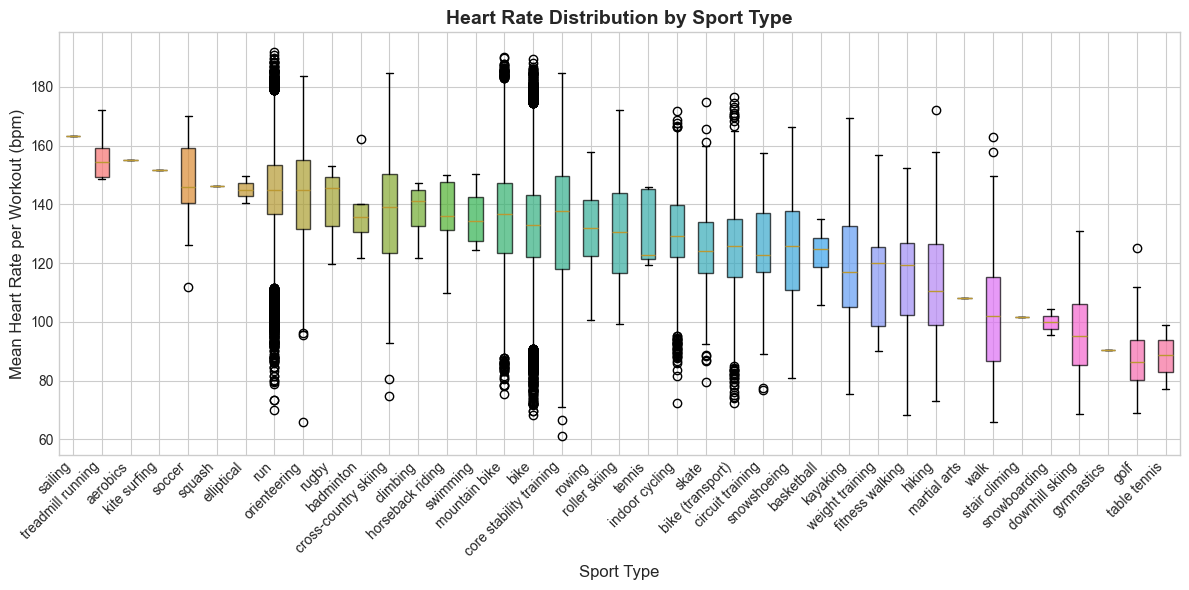

In [24]:
# Visualization: Heart Rate by Sport Type (Box Plot)
plt.figure(figsize=(12, 6))

# Prepare data for box plot
sport_order = sport_hr_df.sort_values('Mean HR', ascending=False)['Sport'].tolist()
box_data = [hr_by_sport[sport] for sport in sport_order]

bp = plt.boxplot(box_data, labels=sport_order, patch_artist=True)

# Color the boxes
colors = sns.color_palette('husl', len(sport_order))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.xlabel('Sport Type', fontsize=12)
plt.ylabel('Mean Heart Rate per Workout (bpm)', fontsize=12)
plt.title('Heart Rate Distribution by Sport Type', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('hr_by_sport.png', dpi=150, bbox_inches='tight')
plt.show()


Mean Heart Rate by Gender:
----------------------------------------
  female: 141.74 bpm (±17.49), n=5,904
  male: 136.68 bpm (±16.68), n=96,239
  unknown: 136.65 bpm (±14.74), n=849


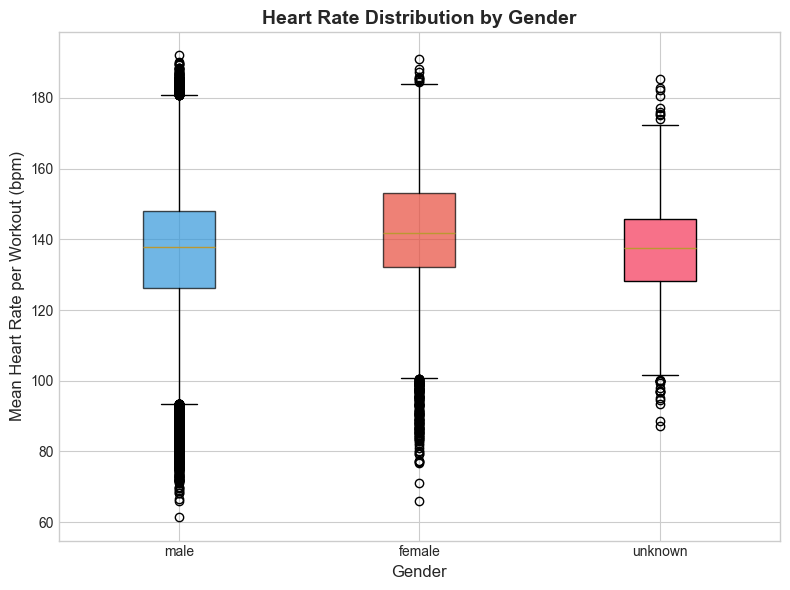

In [25]:
# Heart Rate by Gender
print("\nMean Heart Rate by Gender:")
print("-" * 40)

for gender, hr_list in sorted(hr_by_gender.items()):
    mean_hr = np.mean(hr_list)
    std_hr = np.std(hr_list)
    print(f"  {gender}: {mean_hr:.2f} bpm (±{std_hr:.2f}), n={len(hr_list):,}")

# Visualization
plt.figure(figsize=(8, 6))

gender_order = list(hr_by_gender.keys())
box_data_gender = [hr_by_gender[g] for g in gender_order]

bp = plt.boxplot(box_data_gender, labels=gender_order, patch_artist=True)

colors = ['#3498db', '#e74c3c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.xlabel('Gender', fontsize=12)
plt.ylabel('Mean Heart Rate per Workout (bpm)', fontsize=12)
plt.title('Heart Rate Distribution by Gender', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('hr_by_gender.png', dpi=150, bbox_inches='tight')
plt.show()

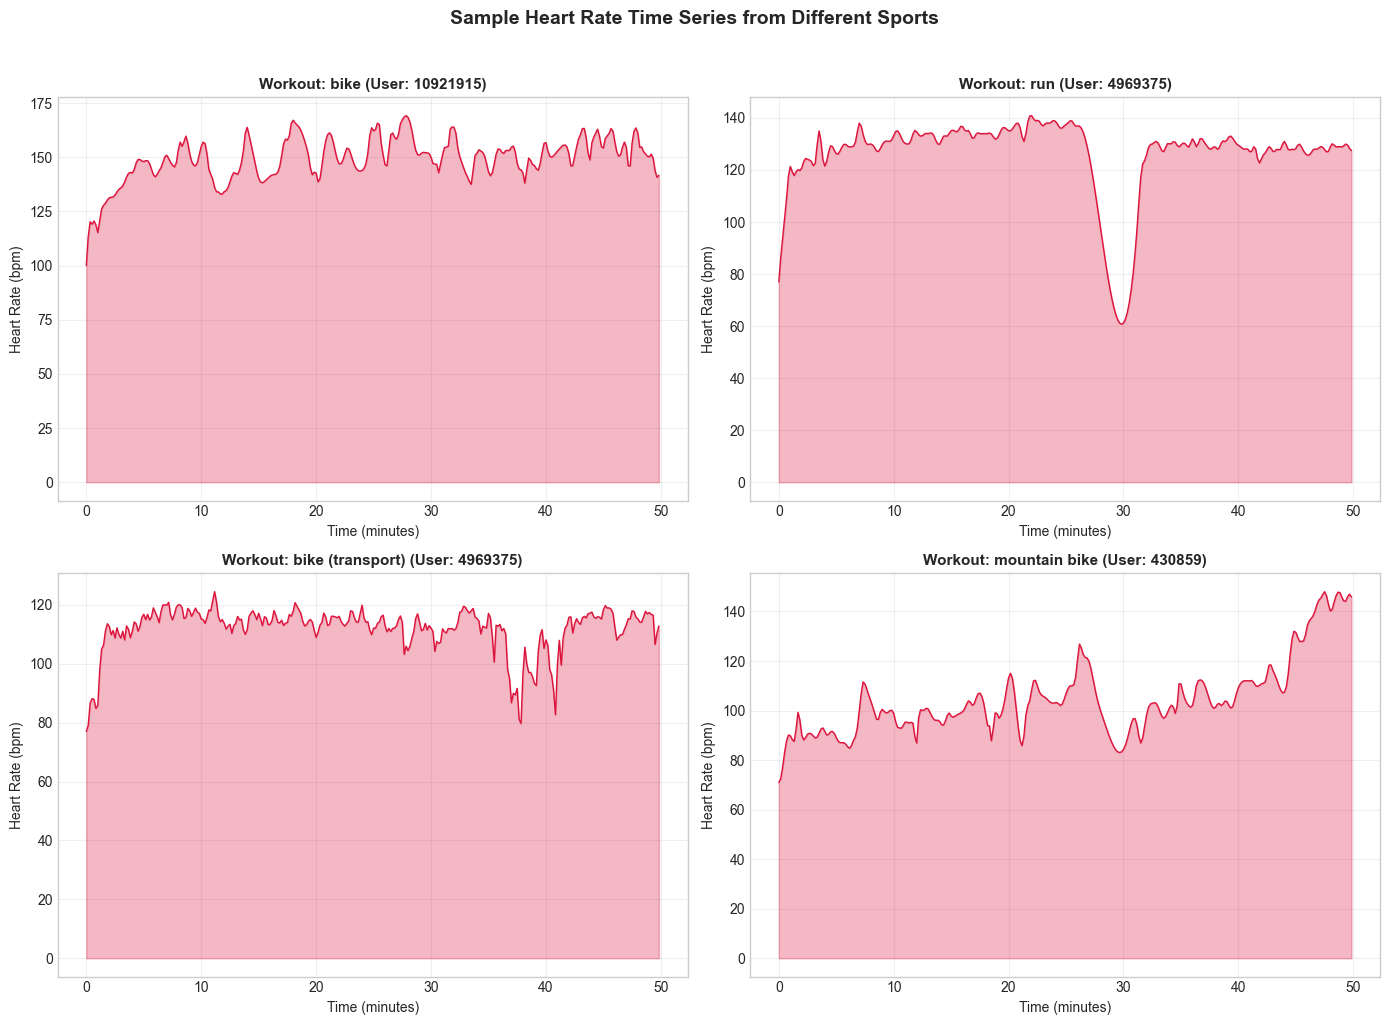

In [26]:
# Sample Heart Rate Time Series
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Select 4 random workouts from different sports
sample_indices = []
seen_sports = set()
for i, workout in enumerate(workouts):
    if workout['sport'] not in seen_sports and len(seen_sports) < 4:
        sample_indices.append(i)
        seen_sports.add(workout['sport'])

for idx, (ax, sample_idx) in enumerate(zip(axes.flat, sample_indices)):
    workout = workouts[sample_idx]
    hr = workout.get('tar_heart_rate', workout.get('heart_rate', []))
    time_points = np.arange(len(hr)) * 10  # 10-second intervals
    
    ax.plot(time_points / 60, hr, color='crimson', linewidth=1)
    ax.fill_between(time_points / 60, hr, alpha=0.3, color='crimson')
    ax.set_xlabel('Time (minutes)', fontsize=10)
    ax.set_ylabel('Heart Rate (bpm)', fontsize=10)
    ax.set_title(f"Workout: {workout['sport']} (User: {workout['userId']})", fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Sample Heart Rate Time Series from Different Sports', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('hr_time_series.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 8: Speed & Distance Analysis

Let's analyze speed and distance data, which are important features for heart rate prediction.

In [27]:
# Collect speed data
all_speeds = []
all_speeds_original = []
speed_by_sport = defaultdict(list)

for workout in workouts:
    speed = workout.get('derived_speed', [])
    speed_orig = workout.get('tar_derived_speed', [])
    sport = workout['sport']
    
    if len(speed) > 0:
        all_speeds.extend(speed)
        if len(speed_orig) > 0:
            all_speeds_original.extend(speed_orig)
            speed_by_sport[sport].append(np.mean(speed_orig))

all_speeds = np.array(all_speeds)
all_speeds_original = np.array(all_speeds_original) if len(all_speeds_original) > 0 else None

print("=" * 60)
print("SPEED ANALYSIS")
print("=" * 60)

print(f"\nNormalized Speed (derived_speed) Statistics:")
print(f"  Min: {np.min(all_speeds):.4f}")
print(f"  Max: {np.max(all_speeds):.4f}")
print(f"  Mean: {np.mean(all_speeds):.4f}")
print(f"  Std: {np.std(all_speeds):.4f}")

if all_speeds_original is not None:
    print(f"\nOriginal Speed (tar_derived_speed) Statistics:")
    print(f"  Min: {np.min(all_speeds_original):.2f}")
    print(f"  Max: {np.max(all_speeds_original):.2f}")
    print(f"  Mean: {np.mean(all_speeds_original):.2f}")
    print(f"  Std: {np.std(all_speeds_original):.2f}")

SPEED ANALYSIS

Normalized Speed (derived_speed) Statistics:
  Min: -7636.0313
  Max: 189514.8014
  Mean: -0.3843
  Std: 195.2560

Original Speed (tar_derived_speed) Statistics:
  Min: -19178.50
  Max: 476441.31
  Mean: 16.84
  Std: 490.86


In [28]:
# Speed by Sport Type
if len(speed_by_sport) > 0:
    print("\nMean Speed by Sport Type:")
    print("-" * 40)
    
    for sport, speed_list in sorted(speed_by_sport.items(), key=lambda x: np.mean(x[1]), reverse=True):
        mean_speed = np.mean(speed_list)
        std_speed = np.std(speed_list)
        print(f"  {sport}: {mean_speed:.2f} (±{std_speed:.2f})")


Mean Speed by Sport Type:
----------------------------------------
  sailing: 24.58 (±0.00)
  bike: 23.48 (±375.42)
  bike (transport): 20.80 (±25.00)
  skate: 19.68 (±7.82)
  kite surfing: 17.94 (±0.00)
  mountain bike: 15.98 (±20.61)
  roller skiing: 13.81 (±5.90)
  horseback riding: 11.00 (±7.36)
  core stability training: 10.66 (±49.95)
  cross-country skiing: 10.16 (±4.30)
  run: 9.63 (±26.49)
  elliptical: 7.51 (±6.36)
  orienteering: 7.50 (±7.87)
  rowing: 7.49 (±9.30)
  kayaking: 6.60 (±4.65)
  fitness walking: 6.12 (±1.25)
  snowboarding: 5.75 (±1.44)
  stair climing: 4.52 (±0.00)
  squash: 4.31 (±0.00)
  walk: 4.06 (±37.97)
  swimming: 3.50 (±1.54)
  hiking: 3.42 (±4.97)
  rugby: 3.31 (±0.88)
  indoor cycling: 3.04 (±8.09)
  snowshoeing: 2.55 (±2.43)
  golf: 2.46 (±1.17)
  downhill skiing: 2.20 (±100.80)
  circuit training: 2.06 (±1.81)
  gymnastics: 1.97 (±0.00)
  climbing: 1.64 (±1.16)
  soccer: 1.46 (±5.89)
  tennis: 1.37 (±0.22)
  badminton: 1.21 (±0.42)
  weight trainin


Correlation between Heart Rate and Speed: 0.0585


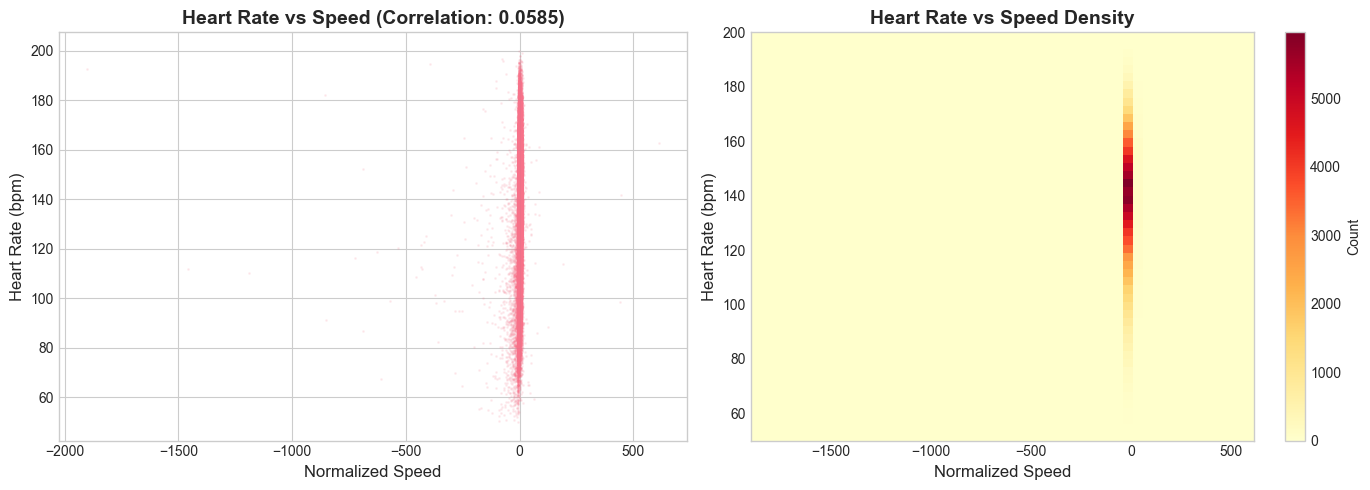

In [29]:
# Heart Rate vs Speed Correlation
# Sample data for scatter plot (too many points otherwise)
sample_size = min(100000, len(all_heart_rates))
indices = np.random.choice(len(all_heart_rates), sample_size, replace=False)

hr_sample = all_heart_rates[indices]
speed_sample = all_speeds[indices] if len(all_speeds) >= sample_size else all_speeds

# Calculate correlation
min_len = min(len(hr_sample), len(speed_sample))
correlation = np.corrcoef(hr_sample[:min_len], speed_sample[:min_len])[0, 1]

print(f"\nCorrelation between Heart Rate and Speed: {correlation:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(speed_sample[:min_len], hr_sample[:min_len], alpha=0.1, s=1)
axes[0].set_xlabel('Normalized Speed', fontsize=12)
axes[0].set_ylabel('Heart Rate (bpm)', fontsize=12)
axes[0].set_title(f'Heart Rate vs Speed (Correlation: {correlation:.4f})', fontsize=14, fontweight='bold')

# 2D Histogram / Density plot
h = axes[1].hist2d(speed_sample[:min_len], hr_sample[:min_len], bins=50, cmap='YlOrRd')
plt.colorbar(h[3], ax=axes[1], label='Count')
axes[1].set_xlabel('Normalized Speed', fontsize=12)
axes[1].set_ylabel('Heart Rate (bpm)', fontsize=12)
axes[1].set_title('Heart Rate vs Speed Density', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('hr_vs_speed.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 9: Temporal Analysis

Let's analyze temporal patterns in the data.

In [30]:
# Workout duration analysis
workout_durations = []  # in minutes
since_begin_values = []
since_last_values = []

for workout in workouts:
    # Duration = number of time points * 10 seconds (interpolation interval)
    n_points = len(workout.get('heart_rate', []))
    duration_minutes = (n_points * 10) / 60
    workout_durations.append(duration_minutes)
    
    # Temporal features
    if 'since_begin' in workout:
        sb = workout['since_begin']
        if isinstance(sb, (list, np.ndarray)):
            since_begin_values.append(sb[0] if len(sb) > 0 else 0)
        else:
            since_begin_values.append(sb)
    
    if 'since_last' in workout:
        sl = workout['since_last']
        if isinstance(sl, (list, np.ndarray)):
            since_last_values.append(sl[0] if len(sl) > 0 else 0)
        else:
            since_last_values.append(sl)

print("=" * 60)
print("TEMPORAL ANALYSIS")
print("=" * 60)

print(f"\nWorkout Duration Statistics (minutes):")
print(f"  Min: {min(workout_durations):.2f}")
print(f"  Max: {max(workout_durations):.2f}")
print(f"  Mean: {np.mean(workout_durations):.2f}")
print(f"  Median: {np.median(workout_durations):.2f}")
print(f"  Std: {np.std(workout_durations):.2f}")

TEMPORAL ANALYSIS

Workout Duration Statistics (minutes):
  Min: 50.00
  Max: 50.00
  Mean: 50.00
  Median: 50.00
  Std: 0.00


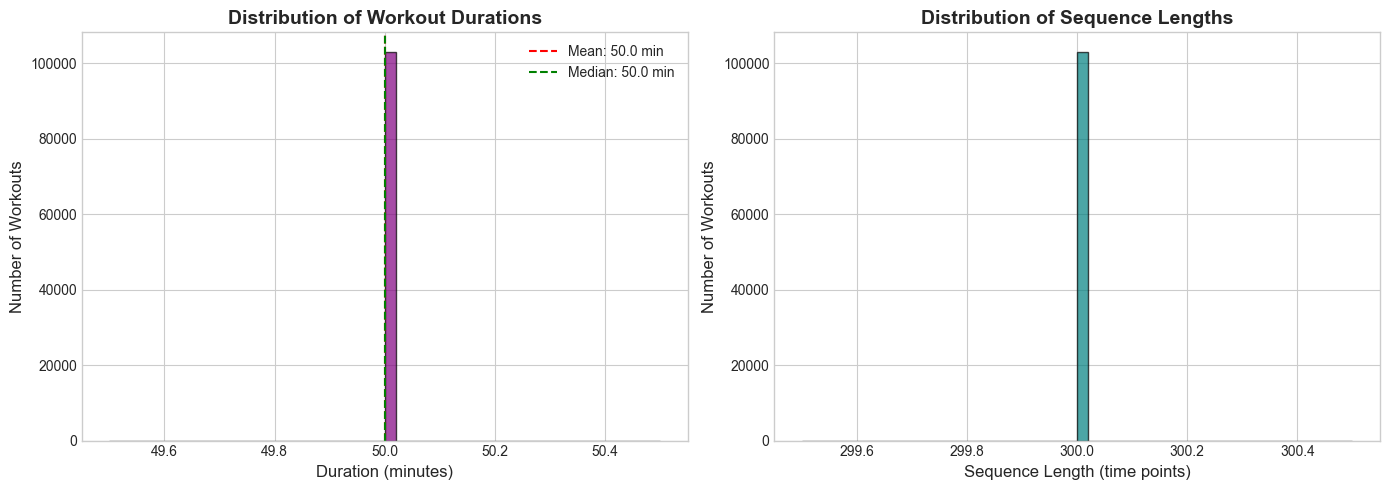

In [31]:
# Visualization: Workout Duration Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of durations
axes[0].hist(workout_durations, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[0].set_xlabel('Duration (minutes)', fontsize=12)
axes[0].set_ylabel('Number of Workouts', fontsize=12)
axes[0].set_title('Distribution of Workout Durations', fontsize=14, fontweight='bold')
axes[0].axvline(np.mean(workout_durations), color='red', linestyle='--', 
                label=f'Mean: {np.mean(workout_durations):.1f} min')
axes[0].axvline(np.median(workout_durations), color='green', linestyle='--', 
                label=f'Median: {np.median(workout_durations):.1f} min')
axes[0].legend()

# Sequence length distribution
axes[1].hist(sequence_lengths, bins=50, edgecolor='black', alpha=0.7, color='teal')
axes[1].set_xlabel('Sequence Length (time points)', fontsize=12)
axes[1].set_ylabel('Number of Workouts', fontsize=12)
axes[1].set_title('Distribution of Sequence Lengths', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('temporal_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [32]:
# Since_begin and Since_last analysis
if len(since_last_values) > 0:
    # Convert to days for better interpretation
    since_last_days = np.array(since_last_values) / (60 * 60 * 24)
    
    print(f"\nTime Since Last Workout (days):")
    print(f"  Min: {np.min(since_last_days):.2f}")
    print(f"  Max: {np.max(since_last_days):.2f}")
    print(f"  Mean: {np.mean(since_last_days):.2f}")
    print(f"  Median: {np.median(since_last_days):.2f}")

if len(since_begin_values) > 0:
    # Convert to days
    since_begin_days = np.array(since_begin_values) / (60 * 60 * 24)
    
    print(f"\nUser Experience - Time Since First Workout (days):")
    print(f"  Min: {np.min(since_begin_days):.2f}")
    print(f"  Max: {np.max(since_begin_days):.2f}")
    print(f"  Mean: {np.mean(since_begin_days):.2f}")
    print(f"  Median: {np.median(since_begin_days):.2f}")


Time Since Last Workout (days):
  Min: -0.00
  Max: 0.02
  Mean: 0.00
  Median: -0.00

User Experience - Time Since First Workout (days):
  Min: -0.00
  Max: 15.95
  Mean: -0.00
  Median: -0.00


---
## Section 10: Correlation Analysis

Let's examine correlations between different features to understand their relationships for predictive modeling.

In [33]:
# Create a DataFrame with aggregated workout-level statistics
workout_stats = []

for workout in workouts:
    stats = {
        'userId': workout['userId'],
        'sport': workout['sport'],
        'gender': workout['gender'],
        'gender_encoded': 1 if workout['gender'] == 'male' else 0,
        'mean_hr': np.mean(workout.get('tar_heart_rate', workout.get('heart_rate', [0]))),
        'std_hr': np.std(workout.get('tar_heart_rate', workout.get('heart_rate', [0]))),
        'mean_speed': np.mean(workout.get('derived_speed', [0])),
        'mean_speed_orig': np.mean(workout.get('tar_derived_speed', [0])),
        'sequence_length': len(workout.get('heart_rate', [])),
        'duration_min': len(workout.get('heart_rate', [])) * 10 / 60
    }
    
    # Add temporal features if available
    if 'since_begin' in workout:
        sb = workout['since_begin']
        stats['since_begin_days'] = (sb[0] if isinstance(sb, (list, np.ndarray)) else sb) / (60*60*24)
    
    if 'since_last' in workout:
        sl = workout['since_last']
        stats['since_last_days'] = (sl[0] if isinstance(sl, (list, np.ndarray)) else sl) / (60*60*24)
    
    workout_stats.append(stats)

workout_df = pd.DataFrame(workout_stats)
print("Workout-level DataFrame created:")
print(workout_df.head(10))
print(f"\nShape: {workout_df.shape}")

Workout-level DataFrame created:
     userId sport gender  gender_encoded     mean_hr     std_hr  mean_speed  \
0  10921915  bike   male               1  149.262166  10.102667    2.889815   
1  10921915  bike   male               1  148.577003  11.167423    3.310221   
2  10921915  bike   male               1  136.919965  10.272722    2.280061   
3  10921915  bike   male               1  146.217599  12.008846    3.436977   
4  10921915  bike   male               1  128.572485  13.171640    2.081560   
5  10921915  bike   male               1  144.222906  15.486624    3.954852   
6  10921915  bike   male               1  145.332322  18.187489    1.593465   
7  10921915  bike   male               1  138.659080  12.361473    1.973733   
8  10921915  bike   male               1  142.314839  16.680163    3.439465   
9  10921915  bike   male               1  155.546643  12.541688    3.695625   

   mean_speed_orig  sequence_length  duration_min  since_begin_days  \
0        25.070638        

In [34]:
# Correlation matrix for numerical features
numerical_cols = ['mean_hr', 'std_hr', 'mean_speed', 'mean_speed_orig', 
                  'sequence_length', 'duration_min', 'gender_encoded']

# Add temporal columns if they exist
if 'since_begin_days' in workout_df.columns:
    numerical_cols.append('since_begin_days')
if 'since_last_days' in workout_df.columns:
    numerical_cols.append('since_last_days')

# Filter to only existing columns
numerical_cols = [col for col in numerical_cols if col in workout_df.columns]

correlation_matrix = workout_df[numerical_cols].corr()

print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)
print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

CORRELATION ANALYSIS

Correlation Matrix:
                  mean_hr  std_hr  mean_speed  mean_speed_orig  \
mean_hr             1.000  -0.131       0.001            0.001   
std_hr             -0.131   1.000      -0.002           -0.002   
mean_speed          0.001  -0.002       1.000            1.000   
mean_speed_orig     0.001  -0.002       1.000            1.000   
sequence_length       NaN     NaN         NaN              NaN   
duration_min          NaN     NaN         NaN              NaN   
gender_encoded     -0.065   0.011       0.004            0.004   
since_begin_days    0.002  -0.002       0.000            0.000   
since_last_days     0.002  -0.002       0.000            0.000   

                  sequence_length  duration_min  gender_encoded  \
mean_hr                       NaN           NaN          -0.065   
std_hr                        NaN           NaN           0.011   
mean_speed                    NaN           NaN           0.004   
mean_speed_orig              

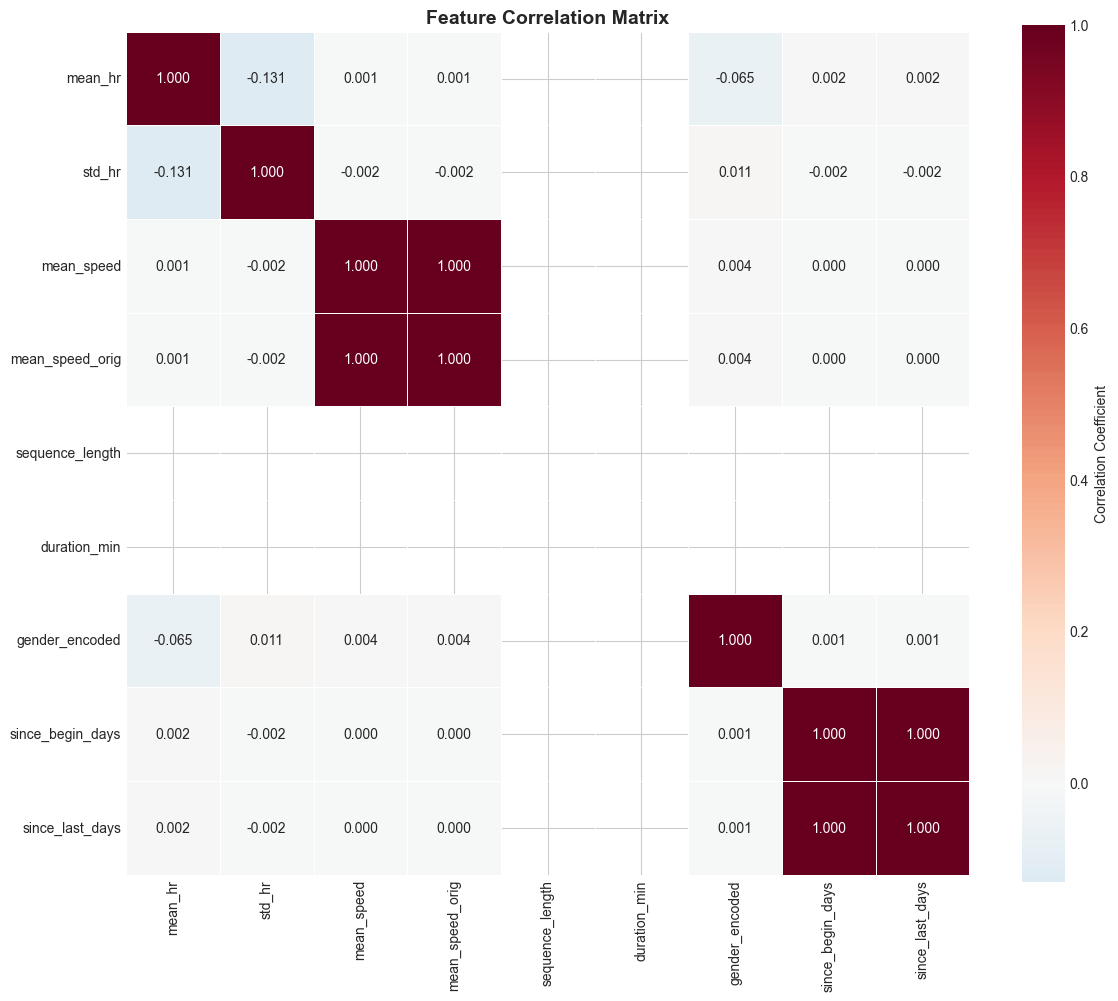

In [35]:
# Visualization: Correlation Heatmap
plt.figure(figsize=(12, 10))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [36]:
# Key correlations with heart rate
print("\nCorrelations with Mean Heart Rate:")
print("-" * 40)
hr_correlations = correlation_matrix['mean_hr'].drop('mean_hr').sort_values(key=abs, ascending=False)
for feature, corr in hr_correlations.items():
    print(f"  {feature}: {corr:.4f}")


Correlations with Mean Heart Rate:
----------------------------------------
  std_hr: -0.1308
  gender_encoded: -0.0653
  since_begin_days: 0.0023
  since_last_days: 0.0023
  mean_speed_orig: 0.0014
  mean_speed: 0.0014
  sequence_length: nan
  duration_min: nan


---
## Section 11: Summary & Insights

### Key Findings from Exploratory Data Analysis

In [37]:
print("=" * 70)
print("SUMMARY OF EXPLORATORY DATA ANALYSIS")
print("=" * 70)

print("\n1. DATASET OVERVIEW")
print("-" * 50)
print(f"   - Total workouts: {len(workouts):,}")
print(f"   - Unique users: {len(set(user_ids)):,}")
print(f"   - Sport types: {len(set(sports))}")
print(f"   - Average workouts per user: {len(workouts)/len(set(user_ids)):.1f}")

print("\n2. MOST COMMON SPORT TYPE")
print("-" * 50)
most_common = sorted_sports[0]
print(f"   - {most_common[0].upper()}: {most_common[1]:,} workouts ({most_common[1]/len(workouts)*100:.1f}%)")

print("\n3. GENDER DISTRIBUTION")
print("-" * 50)
for gender, count in sorted(gender_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"   - {gender}: {count:,} workouts ({count/len(workouts)*100:.1f}%)")

print("\n4. HEART RATE STATISTICS")
print("-" * 50)
print(f"   - Mean: {np.mean(all_heart_rates):.1f} bpm")
print(f"   - Range: {np.min(all_heart_rates):.0f} - {np.max(all_heart_rates):.0f} bpm")
print(f"   - Std: {np.std(all_heart_rates):.1f} bpm")

print("\n5. WORKOUT DURATION")
print("-" * 50)
print(f"   - Mean duration: {np.mean(workout_durations):.1f} minutes")
print(f"   - Median duration: {np.median(workout_durations):.1f} minutes")

print("\n6. KEY CORRELATIONS WITH HEART RATE")
print("-" * 50)
for feature, corr in hr_correlations.head(5).items():
    print(f"   - {feature}: {corr:.4f}")

SUMMARY OF EXPLORATORY DATA ANALYSIS

1. DATASET OVERVIEW
--------------------------------------------------
   - Total workouts: 102,992
   - Unique users: 1,038
   - Sport types: 39
   - Average workouts per user: 99.2

2. MOST COMMON SPORT TYPE
--------------------------------------------------
   - BIKE: 48,493 workouts (47.1%)

3. GENDER DISTRIBUTION
--------------------------------------------------
   - male: 96,239 workouts (93.4%)
   - female: 5,904 workouts (5.7%)
   - unknown: 849 workouts (0.8%)

4. HEART RATE STATISTICS
--------------------------------------------------
   - Mean: 137.0 bpm
   - Range: 50 - 200 bpm
   - Std: 21.7 bpm

5. WORKOUT DURATION
--------------------------------------------------
   - Mean duration: 50.0 minutes
   - Median duration: 50.0 minutes

6. KEY CORRELATIONS WITH HEART RATE
--------------------------------------------------
   - std_hr: -0.1308
   - gender_encoded: -0.0653
   - since_begin_days: 0.0023
   - since_last_days: 0.0023
   - mea

### Implications for Heart Rate Prediction

Based on our exploratory analysis, here are key insights for building a heart rate prediction model:

1. **Target Variable**: We should use `tar_heart_rate` (original heart rate values in bpm) as our prediction target, or `heart_rate` (normalized Z-scores) depending on the modeling approach.

2. **Important Features**:
   - **Speed** (`derived_speed`, `tar_derived_speed`): Likely correlated with heart rate
   - **Sport type**: Different sports have different heart rate patterns
   - **Gender**: May influence baseline heart rate
   - **User history** (`since_begin`, `since_last`): User experience may affect fitness level
   - **Sequence position**: Heart rate changes throughout a workout

3. **Data Characteristics**:
   - Data is already normalized (Z-scores) for some features
   - 10-second sampling intervals provide consistent time series
   - Variable sequence lengths (different workout durations)

4. **Modeling Considerations**:
   - Time series nature of data suggests RNN/LSTM models may be effective
   - User-specific patterns suggest personalization could improve predictions
   - Sport-specific models might outperform general models

### Next Steps

1. Feature engineering for the prediction task
2. Train/validation/test split (consider user-based splitting)
3. Implement baseline models (linear regression, simple averages)
4. Implement advanced models (neural networks, LSTM)
5. Evaluate and compare model performance

In [38]:
print("\n" + "=" * 70)
print("END OF EXPLORATORY DATA ANALYSIS")
print("=" * 70)
print("\nGenerated visualizations saved:")
print("  - sport_distribution.png")
print("  - user_distribution.png")
print("  - gender_distribution.png")
print("  - gender_sport_heatmap.png")
print("  - heart_rate_distribution.png")
print("  - hr_by_sport.png")
print("  - hr_by_gender.png")
print("  - hr_time_series.png")
print("  - hr_vs_speed.png")
print("  - temporal_distribution.png")
print("  - correlation_heatmap.png")


END OF EXPLORATORY DATA ANALYSIS

Generated visualizations saved:
  - sport_distribution.png
  - user_distribution.png
  - gender_distribution.png
  - gender_sport_heatmap.png
  - heart_rate_distribution.png
  - hr_by_sport.png
  - hr_by_gender.png
  - hr_time_series.png
  - hr_vs_speed.png
  - temporal_distribution.png
  - correlation_heatmap.png
